# Simplified 'julia' code for "The modeling of urban races"

## Loading required modules

In [1]:
using Random
using Distributions
using CubicSplines
using Plots
using Random
using Distributions
using LinearAlgebra
using Interpolations
Random.seed!(1234);

## All the settings are introduced in the following cells 

### Numerical model discretization parameters

In [2]:
const racedistance=10000.0 #race length (in meters)
const timestep=0.4 #time step for time discretized method (in seconds)
const observertimestep=1.0 #time interval to save data into memory (in seconds)
const observernsteps=8080 # Number of steps saved into memory for Post-Processing
const endtime=8080.0; #

### Mathematical model parameters

In [3]:
const frontviewdistance=4.0 # Linear distance in front of the runner defining his vital space
const minratio=15.0/40.0 #Min density (ratio of runners per area unit) 
const maxratio=25.0/40.0 #Max density 
const minrho=0.4 #Min value for rho
const maxrho=0.8 #Max value for rho
const posweights=[0.2 0; 2.0 30;  1.5 60;  1.25 120; 1.0 100000] # Parameters defining the metric
const ldist=0.5; #Distance between rows at the starting position (in meters)

### Race settings

In [4]:
const gap=180 # Time gap between consecutive waves
const waves=[3000 166 167 0.0 3.34;
        166  3000 167 (145 +1*gap) 2.92;
        167 167 3000 (283.0+2*gap) 2.5]; # Configuration of wave mixtures 

### Course definition

In [5]:
const coursename="Silvestre"
const courseauxdata=[-500.0 10.0 16.0;
    220.0 (-0.02*220) 16.0;
    260.0 (-0.02*260) 11.0;
    480.0 (-0.02*480) 11.0;
    520.0 (-0.02*520) 6.0;
    1000.0 -20.0 6.0;
    1040.0 -20.0 8.0;
    1500.0 -20.0 8.0;
    2000.0 -20.0 8.0;
    6000.0 -20.0 8.0;
    6500.0 -20.0 8.0;
    7460.0 13.6 8.0;
    7500.0 15.0 16.0;
    8500.0 50.0 16.0;
    10000.0 0.0 16.0;
    10500.0 (-1050.0/3.0+1000.0/3.0) 16.0];

In [6]:
elev_interpolator=LinearInterpolation(courseauxdata[:,1], courseauxdata[:,2],extrapolation_bc=Line())
width_interpolator=LinearInterpolation(courseauxdata[:,1], courseauxdata[:,3],extrapolation_bc=Line())

N=501
auxwidth=zeros(N)
auxlev=zeros(N)
x=range(-500,10500,N)
datainterp=zeros((N,3));

In [7]:
for i in 1:N
    datainterp[i,1]=x[i]
    datainterp[i,2]=elev_interpolator(x[i])
    datainterp[i,3]=width_interpolator(x[i])
end
const coursedata=datainterp; 

### Defining a Team for detailed reports 

In [8]:
#team=rand(1:nrunners,10) #e.g., random 10 runners
team=[478,5891,9345];  #e.g, 3 runners: 1 in the first wave, 1 in the second wave, 1 in the third wave 

### Setting specific data for certain exception runners (may be in the team or not)

In [9]:
# exceptionrunners=[] # No exception runners
# Testing the same runner in the three waves
teamrunner1=[team[1] 38.0 -3.0] # Runner 356 with Average Time 34.0 mnts (per 10Km) and -4.0 Slope Factor
teamrunner2=[team[2] 38.0 -3.0] # Runner 5891 with Average Time 34.0 mnts (per 10Km) and -4.0 Slope Factor
teamrunner3=[team[3] 38.0 -3.0] # Runner 9345 with Average Time 34.0mnts(per 10Km) and -4.3 Slope Factor
exceptionrunners=[teamrunner1, teamrunner2, teamrunner3];

### Plots switch (false= dont show plots)

In [10]:
plots=false 

false

## Parameters  struct

In [11]:
struct Parameters
    timestep::Float32
    observertimestep::Float32
    observernsteps::Int16
    endtime::Float32
    waves::Matrix{Float32}
    frontviewdistance::Float32
    minratio::Float32
    maxratio::Float32
    minrho::Float32
    maxrho::Float32
    posweights::Matrix{Float32}
    ldist::Float32
    numberofwaves::Int8
    nrunners::Int16
    coursename::String
    coursedata::Matrix{Float32}
    racedistance::Float32
end

### Construct the Parameters struct

In [12]:
const numberofwaves=size(waves)[1]
const nrunners=Int(sum(waves[:,1:numberofwaves]))
const parameters=Parameters(timestep,observertimestep,observernsteps, endtime,
               waves,frontviewdistance,minratio,maxratio,minrho,maxrho,
               posweights,ldist, numberofwaves, nrunners, coursename,coursedata,
               racedistance);

## Courses struct

In [13]:
struct Courses
    name::String
    x_data::Vector{Float32}
    diff_data::Vector{Float32}
    width_data::Vector{Float32}
    cspline_elev::CubicSplines.CubicSpline{Float32}
    cspline_width::CubicSplines.CubicSpline{Float32}
    foresightarea_data::Vector{Float32}
end

### Construct the Courses struct

In [14]:
coursename=parameters.coursename
data=parameters.coursedata;
x_data=data[:,1]
diff_data=data[:,2]
width_data=data[:,3]
cspline_elev=CubicSpline(x_data,diff_data)
cspline_width=CubicSpline(x_data,width_data)

# the course is divided in 1 bin per meter
roadstart=0.0
roadend=floor(Int,parameters.racedistance)
roadbins= range(roadstart,roadend-1.0,ceil(Int,parameters.racedistance))
foresightarea_data=zeros(size(roadbins)[1])

for bin in roadbins
    h=parameters.frontviewdistance
    a=bin
    b=a+h
    wa=cspline_width(a)
    wb=cspline_width(b)
    foresightarea_data[floor(Int,bin)+1]=(wa+wb)*h/2.0
end

const course=Courses(coursename,x_data,diff_data,width_data,cspline_elev,cspline_width,foresightarea_data);

## Plot the course elevation gain/loss and width profiles

In [15]:
function plot_diff_course( )
    xs = range(start=minimum(course.x_data), stop=maximum(course.x_data), length=1000)
    ys=course.cspline_elev(xs)
    display(plot(xs, ys,title="Elevation (m)",reuse=false))
end

function plot_width_course()
    xs = range(start=minimum(course.x_data), stop=maximum(course.x_data), length=1000)
    ys=course.cspline_width(xs)
    display(plot(xs, ys,reuse=false, title="Width (m)"))

end

if plots
    plot_diff_course()
    plot_width_course()
end

## Processing waves distribution and setting the speed profiles for the runners
### Generation of average times, slope factors, initial positions, etc

In [16]:
TimeBins=[i for i in 30:100];
ReactionLineTime=parameters.timestep

RunnerDist=[15,18,20,17,18,18,31,40,45,72,96,88,109,131,155,192,
            207,270,281,263,326,298,268,240,309,296,346,313,323,347,
            286,325,281,274,291,252 ,285,220,220,207,213,180,172,145,140,
            151,112,145,96,85,85,87,85,73,42,47,27,39,45,31,28,29,24,21,15,21,14,17,14,12,12]

AcumulatedRelativeRunnerDist=cumsum(RunnerDist/sum(RunnerDist));

In [17]:

function inversepseudosigmoid(exceptionrunnners)
    ldist=parameters.ldist
    nwaves=parameters.numberofwaves
    mixwaves=Int.(parameters.waves[:,1:nwaves])
    wavedelays=parameters.waves[:,nwaves+1]
    waveinitspeeds=parameters.waves[:,nwaves+2]

    partitions=zeros(Float32,size(mixwaves)[1]+1)
    for part in range(1,nwaves)
        partitions[part+1]=partitions[part]+sum(mixwaves[:,part])/nrunners
    end

    println(">Control PreProcessing: partitions ", partitions)
    println(">Control PreProcessing: number of waves",  nwaves)

    waves=zeros(Float32,nrunners)
    wb=1
    we=1

    for wave in range(1, nwaves)
        parts=zeros(Float32,sum(mixwaves[wave, 1 : nwaves]))
        pb=1
        pe=1
        for part in range(1, nwaves)
            size=mixwaves[wave,part]
            pe+=size
            wavepart=rand(Uniform(partitions[part],partitions[part+1]),size)
            parts[pb:pe-1]=wavepart
            pb=pe
        end
        we+=size(parts)[1]
        shuffle!(parts) #mix parts in each wave
        waves[wb:we-1]=parts
        wb=we
    end

    RandDist=waves
    AvgTimes=CubicSpline(AcumulatedRelativeRunnerDist,TimeBins,  extrapl=[1, ], extrapr=[1, ])[RandDist]
    InitPositions=zeros(Float32,nrunners)
    WaveDelays=zeros(Float32,nrunners)
    WaveInitSpeeds=zeros(Float32,nrunners)
    SlopeFactors=rand(Uniform(-13.0,-3.0),nrunners)
    
    # Redefine AvgTimes and SlopeFactors for the exception runners
    if length(exceptionrunners)>0
        for runner in exceptionrunners
            AvgTimes[Int(runner[1])]=runner[2]
            SlopeFactors[Int(runner[1])]=runner[3]
        end
    end

    # Position along the start line
    NinWaves=Int.(zeros(Float32,nwaves))
    for wave in range(1,nwaves)
        NinWaves[wave]=sum(mixwaves[wave, 1: nwaves])
    end

    itemcount=0
    for (nwave,nrunners) in enumerate(NinWaves)
        linecounter=0
        for i in range(1,nrunners)
            # To avoid truncations due to the cubic spline
            auxwidthcontrl=Int(floor(course.cspline_width(-linecounter*ldist)+0.5))

            if (i+1)%auxwidthcontrl==0
                linecounter+=1
            end
            InitPositions[i+itemcount]=-linecounter*ldist#+0.30*np.random.random_sample()-0.15
            WaveDelays[i+itemcount]=wavedelays[nwave]+linecounter*ReactionLineTime
            WaveInitSpeeds[i+itemcount]=waveinitspeeds[nwave]
        end
        itemcount+=nrunners
    end

    return (AvgTimes, RandDist, NinWaves,InitPositions, WaveDelays,WaveInitSpeeds,SlopeFactors)
end

inversepseudosigmoid (generic function with 1 method)

## Setting the speed profiles, initial positions, etc 

In [18]:
const (AvgTimes, RandDist, NinWaves,InitPositions, 
    WaveDelays, WaveInitSpeeds, SlopeFactors)= inversepseudosigmoid(exceptionrunners);

>Control PreProcessing: partitions Float32[0.0, 0.3333, 0.6666, 1.0]
>Control PreProcessing: number of waves3


### Scatter plot of the times distributions accordingly to the wave mixtures

In [19]:
if plots 
    plot(AcumulatedRelativeRunnerDist,CubicSpline(AcumulatedRelativeRunnerDist,TimeBins,
        extrapl=[1, ], extrapr=[1, ])[AcumulatedRelativeRunnerDist],linecolor = :red,lw=2)
    plot!(RandDist,sort(AvgTimes),seriestype = :scatter,title="Random Times Distribution",
        markersize=0.3,markeralpha = 0.4,markercolor = :blue )
end

### Defining a struct for each runner data 

In [20]:
struct Frunner
    time::Float32
    wavedelay::Float32
    waveinitspeed::Float32
    initposition::Float32
    slopefactor::Float32

    avgspeed::Float32
    pos::Vector{Float32}
    vels::Vector{Float32}
    rhos::Vector{Float32}
end

In [21]:
avgspeed(time)=(10000.0/(time*60.0)); # metres per second

In [22]:
function pos(initposition)
    aux=zeros(parameters.observernsteps)
    aux[1]=initposition
    return aux
end

pos (generic function with 1 method)

In [23]:
vels=zeros(parameters.observernsteps)
rhos=zeros(parameters.observernsteps);

In [24]:
Frunner(time,wavedelay,waveinitspeed,initposition,slopefactor)=
Frunner(time,wavedelay,waveinitspeed,initposition,slopefactor,
        avgspeed(time),pos(initposition),vels,rhos);

## Runners struct (container for all data)

In [25]:
mutable struct Runners
    group::Vector{Frunner}
    nrunners::Int16
    pos::Matrix{Float32} 
    vels::Matrix{Float32}
    rhos::Matrix{Float32}
    wavedelays::Vector{Float32}
    waveinitspeeds::Vector{Float32}
    avgspeeds::Vector{Float32}
    slopefactors::Vector{Float32}
end

In [26]:
positions(group)=reduce(hcat,[runner.pos for runner in group])' # ' = transpose
velocities(group)=reduce(hcat,[runner.vels for runner in group])'
rhosall(group)=reduce(hcat,[runner.rhos for runner in group])'
wavedelays(group)=[runner.wavedelay for runner in group]
waveinitspeeds(group)=[runner.waveinitspeed for runner in group]
avgspeeds(group)=[runner.avgspeed for runner in group]
slopefactors(group)=[runner.slopefactor for runner in group];

In [27]:
Runners(group)=Runners(group,
                       nrunners,
                       positions(group),
                       velocities(group),
                       rhosall(group),
                       wavedelays(group),
                       waveinitspeeds(group),
                       avgspeeds(group),
                       slopefactors(group));

## Function for Rho and Group Speed (VL) computation

In [28]:
function RhoVL(R::Vector{Float32},VL::Vector{Float32},X::Vector{Float32},V::Vector{Float32},
               allrunners::Runners,training::Bool)
    minrho=parameters.minrho
    maxrho=parameters.maxrho
    minratio=parameters.minratio
    maxratio=parameters.maxratio
    racedistance=parameters.racedistance
    fvdist=parameters.frontviewdistance
    # sorted indexes of  the runners
    sortedargs=sortperm(X)
    # rho definition (density container)
    #For VL calculation. average of the  slowest in front of the runner
    foresightarea=zeros(Float32,nrunners)

    # First step: counting the number of runner in the frontview  area
     for (arg_idx, arg) in enumerate(sortedargs)
        if X[arg]< 0.0 continue end #start counting only after crossing the starting line
        if X[arg] > racedistance - fvdist continue end #stop near the crossing the finish line
        foresightarea[arg]=course.foresightarea_data[ceil(Int,X[arg])+1]
        #minn rf is the minimum number of runners in the foresight that impacts the runners speed

        minn=floor(Int, minratio*foresightarea[arg]) #min number of  runners for impact area
        maxn=floor(Int, maxratio*foresightarea[arg]) #max number of  runners for impact are
        #println(minn," ",maxn)
        # continue conditions
        if minn<3 continue end #At least 3 runners in the impact area
        if arg_idx+minn>length(sortedargs) continue end
        if X[sortedargs[arg_idx+minn]]-X[arg]>= fvdist continue end

        rhocounter=1.0
        argsofguysinfront=sortedargs[arg_idx+1:min(arg_idx+maxn,nrunners)]
         for arg_i in argsofguysinfront
            if X[arg_i]-X[arg]>fvdist continue
            else rhocounter+=1.0
            end
        end

        if (rhocounter/foresightarea[arg])>maxratio
            R[arg]=maxrho
        elseif ((rhocounter/foresightarea[arg]<=maxratio)
                && (rhocounter/foresightarea[arg]>=minratio))
            D_A=rhocounter/foresightarea[arg]
            R[arg]=(minrho*(D_A-maxratio)-maxrho*(D_A-minratio))/(minratio-maxratio)
        end


        lngth=floor(Int,minn/2) #
        sortedspeeds=sort(V[argsofguysinfront])
        slowersspeeds=sortedspeeds[1:lngth]
        slowersavgspeed=sum(slowersspeeds)/length(slowersspeeds)
        VL[arg]=min(slowersavgspeed,V[arg])
    end
    return R,VL
end

RhoVL (generic function with 1 method)

## Speed function F $(\frac{dx}{dt}=F)$

In [29]:
# Speed function 
function F(t::Float32,X::Vector{Float32},V::Vector{Float32},allrunners::Runners,training::Bool)
    ## Some alias to simplify
    spline=course.cspline_elev
    VL=zeros(Float32,nrunners)
    racedistance=parameters.racedistance
    epsm=100
    R=zeros(Float32,nrunners)

    if training==true
        # Race for timing reports
         for r in 1:nrunners
            # Stop epsm=100m after the finishing line
            if (t <= allrunners.wavedelays[r]) || (X[r]>=racedistance+epsm)
                V[r]=0.0
            else
                V[r]=(allrunners.avgspeeds[r] + gradient(spline,X[r],1)*allrunners.slopefactors[r])
            end 
        end
    elseif training==false

        R, VL = RhoVL(R,VL,X,V,allrunners,training)

         for r in 1:nrunners
            if (t <= allrunners.wavedelays[r]) || (X[r]>=racedistance+epsm)
                V[r]=0.0
            elseif X[r]<0 # This Condition can be improved! (wave propagation in lanes)
                V[r]=min(allrunners.waveinitspeeds[r],allrunners.avgspeeds[r])
            else
                rspeed=(allrunners.avgspeeds[r]+gradient(spline,X[r],1)*allrunners.slopefactors[r])
                V[r]=(1.0-R[r])*rspeed+R[r]*VL[r]
            end
        end

    end
    return V, R
end;

## 2nd order Runge-Kutta solver 

In [30]:
function rk2(allrunners::Runners,training::Bool)
    println(">Control OdeSystemSolvers: Entering rk2_solver")
    
    obsnsteps=parameters.observernsteps
    obststep=parameters.observertimestep
    dt=parameters.timestep
    nsteps=ceil(Int,parameters.endtime/dt)
    println(">Control OdeSystemSolvers: total number of time steps = ", nsteps)
    avgspeeds=allrunners.avgspeeds
    slopefactors=allrunners.slopefactors

    println(">Control OdeSystemSolvers: number of runners = ", nrunners)
    # Container for the solutions
    times=zeros(Float32,obsnsteps)

    # Internal Copy of allrunners.positions
    positions=allrunners.pos
    println(">control OdeSystemSolvers: size(positions)= ", size(positions))
    println(">control OdeSystemSolvers: initial positions= ", positions[nrunners-10:nrunners,1])

    #println(typeof(positions))
    velocities=zeros(Float32,nrunners,obsnsteps)
    rhos=zeros(Float32,nrunners,obsnsteps)

    X1=positions[:,1] #rk Updated positions
    X0=positions[:,1] #rk old positions
    V=velocities[:,1] # useless since it is 0

    K1=zeros(Float32,nrunners)
    K2=zeros(Float32,nrunners)
    R =zeros(Float32,nrunners)
    
    j=0
    for i in 0:(nsteps-1)
        t=dt*i
        V, R = F(t,X0, V, allrunners,training) #update velocities
        K1=dt .* V
        V, R = F(t+dt, X0 .+ K1, V, allrunners,training) #update velocities
        K2=dt .* V
        X1=X0 .+ 0.5 .* (K1 .+ K2) # update positions

        ## Containers for Observer
        if ((i+1)*dt>=(obststep*j) && i*dt<=(obststep*j))
            delta=(j*obststep-i*dt)/dt
            beta=1.0-delta
            times[j+1]=obststep*(j+1)
            ## interpolations
            positions[:,j+1]= beta .* X0 .+ delta .*X1
            velocities[:,j+1]=V #beta .* velocities[:,j] .+delta.* V
            rhos[:,j+1]=R #beta .* rhos[:,j] .+ delta .* R
            if (j+1 == obsnsteps) break end
            j+=1
        end
        X0[:] .= X1[:]
    end

    return times, positions,velocities, rhos
end;
solver=rk2

rk2 (generic function with 1 method)

## Race processing function

In [31]:
function race(raceswitch::Bool)
    if raceswitch==true strng="Race"
    else strng="Training"
    end
    println(">control $strng: model")
    runnerslist=Array{Frunner,1}(undef, nrunners)
    for i in 1:nrunners
        runnerslist[i]=Frunner(AvgTimes[i],WaveDelays[i],WaveInitSpeeds[i],InitPositions[i],SlopeFactors[i])
    end
    allrunners=Runners(runnerslist)
    println(">control $strng: sizes(allrunners.group)= ", size(allrunners.group))
    println(">control $strng: Pre-Processing done")
    println(">control $strng: Starting $strng Simulation")
    times, allrunners.pos, allrunners.vels, allrunners.rhos=solver(allrunners,!raceswitch)
    println(">Control $strng: Processing done")
    return times, allrunners
end

race (generic function with 1 method)

## Training race (free running)

In [32]:
t=@elapsed begin 
    times , alltrainees = race(false) 
end
println(">Elapsed time=", t)

>control Training: model
>control Training: sizes(allrunners.group)= (10000,)
>control Training: Pre-Processing done
>control Training: Starting Training Simulation
>Control OdeSystemSolvers: Entering rk2_solver
>Control OdeSystemSolvers: total number of time steps = 20200
>Control OdeSystemSolvers: number of runners = 10000
>control OdeSystemSolvers: size(positions)= (10000, 8080)
>control OdeSystemSolvers: initial positions= Float32[-103.5, -103.5, -103.5, -104.0, -104.0, -104.0, -104.0, -104.0, -104.0, -104.0, -104.0]
>Control Training: Processing done
>Elapsed time=122.276354505


## Race

In [33]:
t= @elapsed begin 
        _ , allrunners= race(true)
end
println(">Elapsed time=", t)

>control Race: model
>control Race: sizes(allrunners.group)= (10000,)
>control Race: Pre-Processing done
>control Race: Starting Race Simulation
>Control OdeSystemSolvers: Entering rk2_solver
>Control OdeSystemSolvers: total number of time steps = 20200
>Control OdeSystemSolvers: number of runners = 10000
>control OdeSystemSolvers: size(positions)= (10000, 8080)
>control OdeSystemSolvers: initial positions= Float32[-103.5, -103.5, -103.5, -104.0, -104.0, -104.0, -104.0, -104.0, -104.0, -104.0, -104.0]
>Control Race: Processing done
>Elapsed time=216.542981214


## Post-Processing functions

### Positions snapshot

In [34]:
function snapshot(steps,allrunners,ninwaves)
    xs = range(start=minimum(course.x_data), stop=maximum(course.x_data), length=1000)
    ys=course.cspline_elev(xs)
    ws=course.cspline_width(xs)
    yws=ys .+ ws

    println("Control PostProcessing: number of snapshots ", length(steps))
    for step in steps
        time=Int(step*parameters.observertimestep)
        X=allrunners.pos[:, step]
        YWS=zeros(nrunners)
        for r in 1:nrunners
            YWS[r]=rand(Uniform(0,1))*course.cspline_width(X[r])+course.cspline_elev(X[r])
        end

        colors=["orange","cyan","green","purple","brown","pink","gray","azure","olive","blue"]
        nwaves=size(ninwaves)[1]

        plot(xs, ys,title="Race Snapshot t=$time (s)",label="Elevation")
        xlabel!("Course length (m)")
        ylabel!("Course elevation (m)")
        plot!(xs,yws,label="Width")
        wb=1
        we=0
        n=0
        for (color,counter) in zip(colors[1:nwaves],ninwaves)
            n+=1
            we+=counter
            plot!(X[wb:we],YWS[wb:we],seriestype = :scatter,
                  markersize=0.3,
                  markeralpha = 1.0,
                  markerstrokecolor =color,
                  label="wave $n")
            wb=we+1
        end
        display(plot!(size=(900,275))) 
        #tm=lpad(time,4,"0")
        #savefig("./reports/pngs/snapshot$tm.png")
    end
end


snapshot (generic function with 1 method)

### Histogram snapshot

In [35]:
function histsnapshot(steps,allrunners)
    println("Control PostProcessing: number of histsnapshots ", length(steps))
    for step in steps
        bins=0:round(Int,parameters.frontviewdistance):round(Int,parameters.racedistance)
        display(histogram(allrunners.pos[:,step],bins=bins,label=false,ylims=(0,100),size=(900,300)))
        xlabel!("Road (m)")
        ylabel!("Runners per $parameters.frontviewdistance (m)")
    end
end

histsnapshot (generic function with 1 method)

### Motion profiles

In [36]:
function motionvisuals(runnersidxs,allrunners,times)
    plot(title="Motion profile")
    xlabel!("Time (s)")
    ylabel!("Position (m)")
    for runner in runnersidxs
        plot!(times,allrunners.pos[runner,:],lw=0.5,label=string(runner))#,label=false)
    end
    display(plot!(size=(800,400)))
end

motionvisuals (generic function with 1 method)

### Speed profiles

In [37]:
function speedsvisuals(runnersidxs,allrunners,times)
    plot(title="Speed Profile")
    xlabel!("Time (s)")
    ylabel!("Speed (m/s)")

    for runner in runnersidxs #range(group.size):
        plot!(times,allrunners.vels[runner,:],lw=0.5,label=string(runner))
    end
    display(plot!(size=(800,400)))
end

speedsvisuals (generic function with 1 method)

### Phase (x=position,y=speed)

In [38]:
function phasevisuals(runnersidxs,allrunners)
    plot(title="Phase Profile")
    xlabel!("Position (m)")
    ylabel!("Speed (m/s)")
    for runner in runnersidxs
        plot!(allrunners.pos[runner,:],allrunners.vels[runner,:],lw=0.5,label=string(runner))
    end
    display(plot!(size=(800,400)))
end

phasevisuals (generic function with 1 method)

### Rho profiles

In [39]:
function rhosvisuals(runnersidxs,allrunners,times)
    plot(title="Rho Profile")
    xlabel!("Time (s)")
    ylabel!("Rho")

    for runner in runnersidxs
        plot!(times,allrunners.rhos[runner,:],ms=3,label=string(runner),seriestype = :scatter)
    end
    display(plot!(size=(800,400)))
end

rhosvisuals (generic function with 1 method)

In [40]:
function burstsvisuals(runnersidxs,allrunners,times,gap)
    bursts=zeros(length(runnersidxs))
    for (idx,runner) in enumerate(runnersidxs)
        bursts[idx]=sum(x->x>0.3,allrunners.rhos[runner,:]) 
    end
    
    plot(title="Number of at least"*string(gap)*"seconds blocks running slower")
    plot!(runnersidxs,bursts,ms=3,seriestype = :scatter)
    display(plot!(size=(800,400)))
end

burstsvisuals (generic function with 1 method)

## Post-Processing

In [41]:
if plots
    snapshot(4000,allrunners,NinWaves)
end

#### Density of runners in a certain time step 

In [42]:
if plots 
    histsnapshot(1000,allrunners)
end

#### Plot the position of certain runners as function of time

In [43]:
if plots
    motionvisuals(team,allrunners,times)
end

#### Plot the speed of certain runners as function of time

In [44]:
if plots
    speedsvisuals(team,allrunners,times)
end

#### Plot the speed of certain runners as function of their positions (optionl/debug)

In [45]:
if plots
    phasevisuals(team,allrunners)
end

#### Plot the evolution of Rho for certain runners

In [46]:
if plots
    rhosvisuals(team,allrunners,times)
end

#### Plot the number of instants where the velocity is affected by density 

In [47]:
if plots 
    burstsvisuals(1:nrunners,allrunners,times,1) #Counting bursts for all runners
end

## Extra Post-Processing:
### Functions for race (partial) timings, metrics and team reports

### Defining partial distances for Post-Processing times

In [48]:
dists=500.0 .* [x for x in 1:20] # Partial distances
ndists=length(dists)
bdt=10.0; #Time interval for bursts measurement

In [49]:
function reports(times,allrunners,allrunners_training,team)
    par=parameters
    ndists=length(dists)
    starttimes=zeros(nrunners)
    endtimes=zeros((nrunners,ndists))
    runnertimes=zeros((nrunners,ndists))
    

    for runner in 1:nrunners
        tsidx=findfirst(x->(x>0.0), allrunners.pos[runner,:])
        starttimes[runner]=times[tsidx]
        for (idx,dist) in enumerate(dists)
            teidx=findfirst(x->(x > dist),allrunners.pos[runner,:])
            endtimes[runner,idx]=times[teidx]
        end
    end
    
    println(">control Post-Processing: Waves=")
    println(par.waves)
    r0=1
    r1=sum(Int,par.waves[1, 1:par.numberofwaves])
    wave_departure=maximum(starttimes[r0:r1])
    wave_time_gap_to_cross=maximum(starttimes[r0:r1])-minimum(starttimes[r0:r1])+1
    println(">control Post-Processing: departures computation")
    println(">control Post-Processing: departures: wave: ",1, " departure:",  wave_departure)
    println(">control Post-Processing: departures: wave: ",1, " time gap to cross:",  wave_time_gap_to_cross)

    wavetxt=" ["*string(par.waves[1,1:size(par.waves)[1]])[9: end-1]*" ,0.0 ,"*string(par.waves[1,end])*"]"
    acumulated_wave_time_gap_to_cross=wave_time_gap_to_cross


    for j in range(2,size(par.waves)[1])
        r0+=sum(Int,par.waves[j-1, 1: par.numberofwaves])
        r1=r0+sum(Int,par.waves[j,1: par.numberofwaves])-1
        wave_departure=maximum(starttimes[r0:r1])
        wavetxt*="\n ["*string(par.waves[j,1:size(par.waves)[1]])[9:end-1]*","*string(acumulated_wave_time_gap_to_cross)*
        " + "*string(j-1)*"*gap ,"*string(par.waves[j,end])*"]"
        wave_time_gap_to_cross=maximum(starttimes[r0:r1])-minimum(starttimes[r0:r1])+1
        acumulated_wave_time_gap_to_cross+=wave_time_gap_to_cross
        println(">control Post-Processing: departures: wave: ",j, " departure:",  wave_departure)
        println(">control Post-Processing: departures: wave: ",j, " time gap to cross: ",  wave_time_gap_to_cross)
    end

    println(">control Post-Processing: suggested setting for waves after initial running for tune settings")
    println(">control Post-Processing: ********************************************************")
    println(wavetxt)
    println(">control Post-Processing: *********************************************************")

    for runner in 1:nrunners
        for idx in 1:ndists
            runnertimes[runner,idx]= endtimes[runner,idx]-starttimes[runner]
        end
    end
    
    racetime=maximum(endtimes[:,ndists])
    slowrunners=argmax(endtimes[:,ndists])
    mintime=minimum(runnertimes[:,ndists])
    worsttime=maximum(runnertimes[:,ndists])
    winrunners=argmin(runnertimes[:,ndists])
    losrunners=argmax(runnertimes[:,ndists])

    starttimes_training=zeros(nrunners)
    endtimes_training=zeros((nrunners,ndists))
    runnertimes_training=zeros((nrunners,ndists))

    for runner in 1:nrunners
        tsidx=findfirst(x->(x>0.0), allrunners_training.pos[runner,:])
        starttimes_training[runner]=times[tsidx]
        for (idx,dist) in enumerate(dists)
            teidx=findfirst(x->(x > dist),allrunners_training.pos[runner,:])
            endtimes_training[runner,idx]=Int(times[teidx])
        end
    end
    
     for runner in 1:nrunners
        for idx in 1:ndists
            runnertimes_training[runner,idx]=endtimes_training[runner,idx]-starttimes_training[runner]
        end
    end
   
    errors=zeros((nrunners,ndists))
    for runner in 1:nrunners
        for idx in 1:ndists
            errors[runner,idx]=ceil(runnertimes[runner,idx])-floor(runnertimes_training[runner,idx])
        end
    end
    
    println(">control Post-Processing: departure: runners  affected by the velocity rule at departure ",
          length(findall(x->(x!=0.0),starttimes-starttimes_training)), " (in seconds)")
    println(">control Post-Processing: par.posweights=")
    println(par.posweights)

    t1=par.posweights[2,2]
    t2=par.posweights[3,2]
    t3=par.posweights[4,2]
    t4=par.posweights[5,2]
    
    w0=par.posweights[1,1]
    w1=par.posweights[2,1]
    w2=par.posweights[3,1]
    w3=par.posweights[4,1]
    w4=par.posweights[5,1]


    errorspen=zeros(nrunners)
    count_t1=0
    count_t2=0
    count_t3=0
    count_t4=0

    for (idx,error) in enumerate(errors[:,ndists])
        if error <= t1
            errorspen[idx]=error*w1
            count_t1+=1
        elseif t1 < error <= t2
            errorspen[idx]=w1*t1+(error-t1)*w2
            count_t2+=1
        elseif t2 < error <= t3
            errorspen[idx]=w1*t1+(t2-t1)*w2+(error-t2)*w3
            count_t3+=1
        else
            errorspen[idx]=w1*t1+(t2-t1)*w2+(t3-t2)*w3+(error-t3)*w4
            count_t4+=1
        end
    end
    println(">control Post-Processing: number of runners with time loss in [0,", t1,"] is ", count_t1)
    println(">control Post-Processing: number of runners with time loss in ]",t1,",", t2,"] is ", count_t2)
    println(">control Post-Processing: number of runners with time loss in ]",t2,",", t3,"] is ", count_t3)
    println(">control Post-Processing: number of runners with time loss > ",t3, " is ", count_t4)

    errorspen .+= w0 .* starttimes
    println(">control Post-Processing: waves description: errors computation for metric")
    r0=1
    r1=1
     for j in range(2,size(par.waves)[1])
         r0+=sum(Int,par.waves[j-1, 1:par.numberofwaves])
         r1=r0+sum(Int,par.waves[j, 1:par.numberofwaves])
         errorspen[r0:r1-1].-= w0.*par.waves[j,par.numberofwaves+1]
         println(">control Post-Processing:  wave ",
                 j-1, "start: ",r0," wave end: ",r1-1,", ",par.waves[j,par.numberofwaves+1])
     end

    println(">control Post-Processing: race time: ", racetime, " (in seconds)")
    println(">control Post-Processing: slowest racer: ", slowrunners)
    println(">control Post-Processing: best race time: ", mintime, " (in seconds)")
    println(">control Post-Processing: winner: ", winrunners)
    println(">control Post-Processing: worst race time: ", worsttime, " (in seconds)")
    println(">control Post-Processing: last: ", losrunners)
    
    losttimesperkm=zeros(Int,(nrunners,ndists))
    for runner in 1:nrunners
        losttimesperkm[runner,1]=errors[runner,1]
        for idx in 2:ndists
            losttimesperkm[runner,idx]=ceil(Int,errors[runner,idx])-floor(Int,errors[runner,idx-1])
        end
    end

    metricerror=sum(errorspen)/length(errorspen)
    println(">control Post-Processing: metric error: ", metricerror)
    l1error=norm(errors[:,ndists],1)/length(errors[:,ndists])
    println(">control Post-Processing: Average lost time (l1 error): ", l1error, " (in seconds)")
    println(">control Post-Processing: Average lost time per runner per partial distance: ") 
    println(">=",ceil.(Int,mean(losttimesperkm,dims=1)), " (in seconds)")
    println(">control Post-Processing: Counter of runners that lost >",bdt,"(s) in each partial distance: ") 
    
    counters=zeros(Int,ndists)
    for i in 1:ndists
        counters[i]=count(x->(x>bdt),losttimesperkm[:,i])
    end
    println(">",counters)
    
    sortedargs=sortperm(runnertimes[:,ndists])
    println(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    println(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    println(">control Post-Processing: team runners")
    for runneridx in team
        println(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
        println(">control Post-Processing: runner[$runneridx]")
        println(">control Post-Processing: Average speeds=", allrunners.avgspeeds[runneridx], " (in metre per second)")
        println(">control Post-Processing: Slope factor=", allrunners.slopefactors[runneridx])
        println(">control Post-Processing: Wave delay time=", allrunners.wavedelays[runneridx], " (in seconds)")
        println(">control Post-Processing: Initial position=", allrunners.pos[runneridx,1]," (in metres)")
        println(">control Post-Processing: Race time=")
        println(">=",runnertimes[runneridx,:]," (in seconds)")
        println(">control Post-Processing: Finishing time=")
        println(">=",endtimes[runneridx,:], " (in seconds)")
        println(">control Post-Processing: Cumulative Lost times per Km=")
        println(">=",errors[runneridx,:], " (in seconds)")
        println(">control Post-Processing: Lost time per Km=")
        println(">=",losttimesperkm[runneridx,:], " (in seconds)")
        println(">control Post-Processing: Metric error=", errorspen[runneridx])
        println(">control Post-Processing: Final position=",findfirst(x->x==runneridx,sortedargs))
    end
    
    return  runnertimes, runnertimes_training,errors,errorspen,racetime, losttimesperkm
    
end

reports (generic function with 1 method)

In [50]:
function plottimes(runnertimes,runnertimes_training)
     plot(1:nrunners,runnertimes[:,ndists],ms=0.5,label="Race",seriestype = :scatter,
         markerstrokecolor = "orange",
         reuse=false)
    ylabel!("Time in seconds")
    xlabel!("Runner index")
    plot!(team,runnertimes[team,ndists],seriestype = :scatter, markercolor = "orange",label=false)
    plot!(team,runnertimes_training[team,ndists],seriestype = :scatter, markercolor = "blue",label=false)
    display(plot!(1:nrunners,runnertimes_training[:,ndists],ms=0.5,label="Training",seriestype = :scatter,
         markerstrokecolor ="blue"))
end

plottimes (generic function with 1 method)

In [51]:
function ploterrors(errors,errorspen,racetime)
    metricerror=sum(errorspen)/length(errorspen)
    l1error=norm(errors[:,ndists],1)/length(errors[:,ndists])
    plot(1:nrunners,errors[:,ndists],ms=0.5,label="Time lost",
        seriestype = :scatter, markerstrokecolor = "orange",
        title="Averaged time and metric losses = "*string(round(Int,l1error))*", "
         *string(round(Int,metricerror)),reuse=false)
    ylabel!("Time in seconds (total race time: "*string(ceil(Int,racetime))*")")
    xlabel!("Runner index")
    plot!(team,errors[team,ndists],seriestype = :scatter, markercolor = "orange",label=false)
    plot!(team,errorspen[team],seriestype = :scatter, markercolor = "blue",label=false)
    display(plot!(1:nrunners,errorspen,ms=0.5,label="Metric score",
            seriestype = :scatter, markerstrokecolor = "blue"))
end

ploterrors (generic function with 1 method)

In [61]:
function burstshistogram(losttimesperkm)
    burstcounters=zeros(Int,nrunners)
    for runner in 1:nrunners
        burstcounters[runner]=count(x->(x>bdt),losttimesperkm[runner,:])
    end
    h=histogram(burstcounters,bins=ndists,label=false,bar_width=0.8,dpi=300)
    xticks!([i+0.5 for i in 0:ndists],[string(i) for i in 0:ndists])
    xlabel!("Number of bursts")
    ylabel!("Number of runners")
    display(h)
    savefig("./hist.png")
end

burstshistogram (generic function with 1 method)

### Race reports and more plots

In [53]:
rt,rt_t,e,ep,rct,lt=reports(times,allrunners,alltrainees,team);

>control Post-Processing: Waves=
Float32[3000.0 166.0 167.0 0.0 3.34; 166.0 3000.0 167.0 325.0 2.92; 167.0 167.0 3000.0 643.0 2.5]
>control Post-Processing: departures computation
>control Post-Processing: departures: wave: 1 departure:146.0
>control Post-Processing: departures: wave: 1 time gap to cross:145.0
>control Post-Processing: departures: wave: 2 departure:464.0
>control Post-Processing: departures: wave: 2 time gap to cross: 139.0
>control Post-Processing: departures: wave: 3 departure:789.0
>control Post-Processing: departures: wave: 3 time gap to cross: 146.0
>control Post-Processing: suggested setting for waves after initial running for tune settings
>control Post-Processing: ********************************************************
 [3000.0, 166.0, 167.0 ,0.0 ,3.34]
 [166.0, 3000.0, 167.0,145.0 + 1*gap ,2.92]
 [167.0, 167.0, 3000.0,284.0 + 2*gap ,2.5]
>control Post-Processing: *********************************************************
>control Post-Processing: departure: ru

In [54]:
if plots 
    plottimes(rt,rt_t)
end

In [55]:
if plots
    ploterrors(e,ep,rct)
end

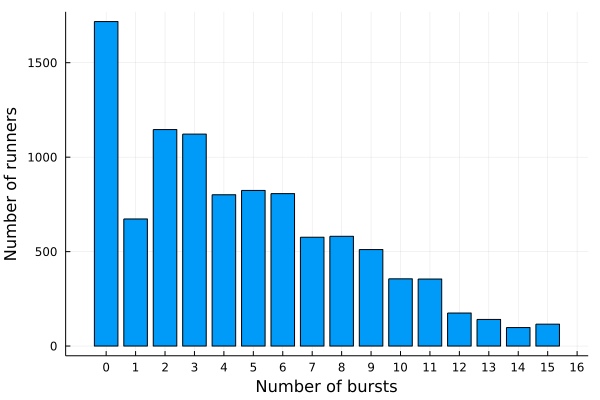

In [62]:
if true
    burstshistogram(lt)
end